# Validity check for Koopman eigenfunctions

The linearity, and thus the model performance, of a Koopman model can be analyzed by
comparing the linearity of the eigenfunctions evaluated on a test trajectory and the
prediction using the corresponding eigenvalue. This will be demonstrated in this
tutorial for a two-dimensional system evolving on a slow manifold. 

For details we
refer to 
- Kaiser, Kutz & Brunton, _"Data-driven discovery of Koopman
eigenfunctions for control"_, Machine Learning: Science and Technology, Vol. 2(3), 035023, 2021,
- Korda & Mezic, _"Optimal construction of Koopman eigenfunctions for
prediction and control"_, IEEE Transactions on Automatic Control, Vol. 65(12), 2020.

In [1]:
import pykoopman as pk
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from pykoopman.common import slow_manifold
nonlinear_sys = slow_manifold(mu=-0.1, la=-1.0, dt=0.1)

### Collect training data

In [2]:
n_int = 1
n_pts = 51
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))

X, Y = nonlinear_sys.collect_data_discrete(Xdat, n_int)

### Test trajectory

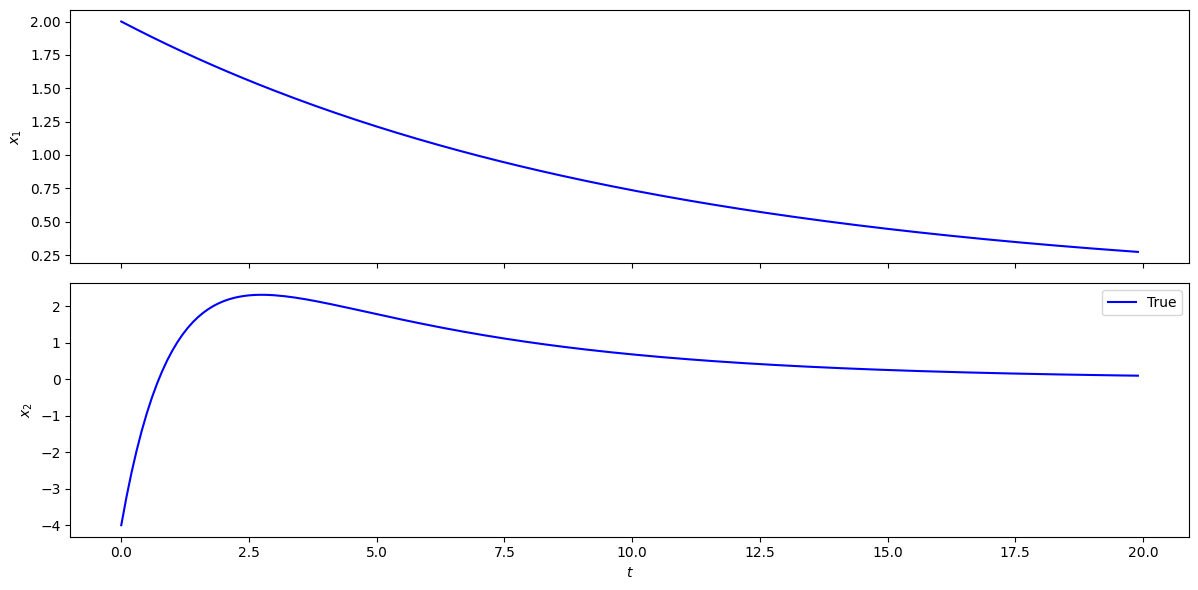

In [3]:
x0 = np.array([2, -4])  #np.array([2, -4])
T = 20
t = np.arange(0, T, nonlinear_sys.dt)
Xtest = nonlinear_sys.simulate(x0[:, np.newaxis], len(t)-1).T
Xtest = np.vstack([x0[np.newaxis, :], Xtest])
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(12, 6))
axs[0].plot(t, Xtest[:, 0], '-', color='blue', label='True')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtest[:, 1], '-', color='blue', label='True')
axs[1].set(ylabel=r'$x_2$', xlabel=r'$t$')
axs[1].legend(loc='best')

### Learn Koopman EDMD model on training data

In [4]:
regr = pk.regression.EDMD()
obsv = pk.observables.Polynomial(degree=3)
model = pk.Koopman(observables=obsv, regressor=regr)
model.fit(X.T, y=Y.T, dt=nonlinear_sys.dt)

Koopman(observables=Polynomial(degree=3), regressor=EDMD())

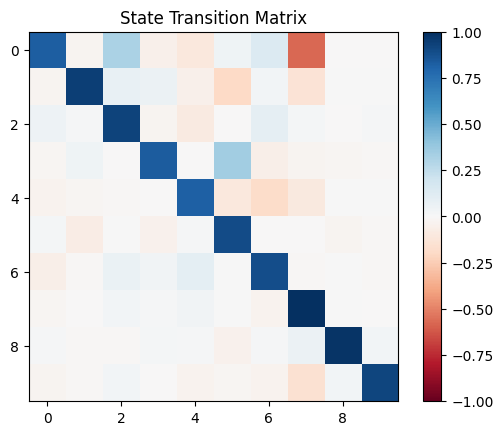

In [5]:
fig = plt.figure()
ax0 = plt.subplot(111)
im = ax0.imshow(model.A, aspect='equal', cmap=plt.get_cmap
('RdBu'), vmin=-1, vmax=1)
ax0.set(title='State Transition Matrix')
fig.colorbar(im, ax=ax0)

### Evaluate model performance on test trajectory

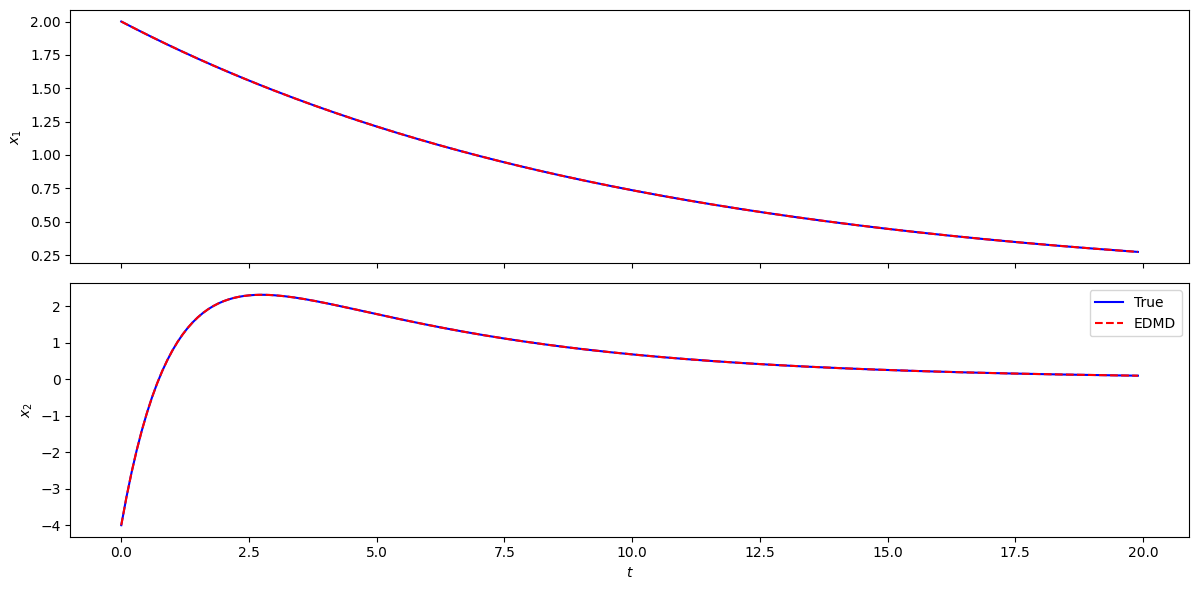

In [6]:
Xkoop = model.simulate(x0[np.newaxis, :], n_steps=len(t)-1)
Xkoop = np.vstack([x0[np.newaxis,:], Xkoop])

fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(12, 6))
axs[0].plot(t, Xtest[:, 0], '-', color='blue', label='True')
axs[0].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtest[:, 1], '-', color='blue', label='True')
axs[1].plot(t, Xkoop[:, 1], '--r', label='EDMD')
axs[1].set(ylabel=r'$x_2$', xlabel=r'$t$')
axs[1].legend(loc='best')

### Evaluate linearity of identified Koopman eigenfunctions

Koopman eigenfunctions evolve linearly in time and must satisfy:

$$\phi(x(t)) = \phi(x(0)) \exp(\lambda t)$$

It is possible to evaluate this expression on a test trajectory $x(t)$ with a
linearity error defined by:

$$e = \Vert \phi(x(t)) - \phi(x(0)) \exp(\lambda t) \Vert$$

In [7]:
efun_index, linearity_error = model.validity_check(t, Xtest)
print("Ranking of eigenfunctions by linearity error: ", efun_index)
print("Corresponding linearity error: ", linearity_error)

Ranking of eigenfunctions by linearity error:  [5 7 4 6 8 9 1 0 3 2]
Corresponding linearity error:  [1.042151265907488e-12, 1.703589523406232e-12, 2.596553953720182e-12, 3.5641002115347794e-12, 5.00412411274413e-12, 8.203839104974664e-12, 16.332095551664978, 39.73112119201276, 72.0873036483041, 72.69373076541768]


### Visualization of eigenfunction/-value prediction on test trajectory

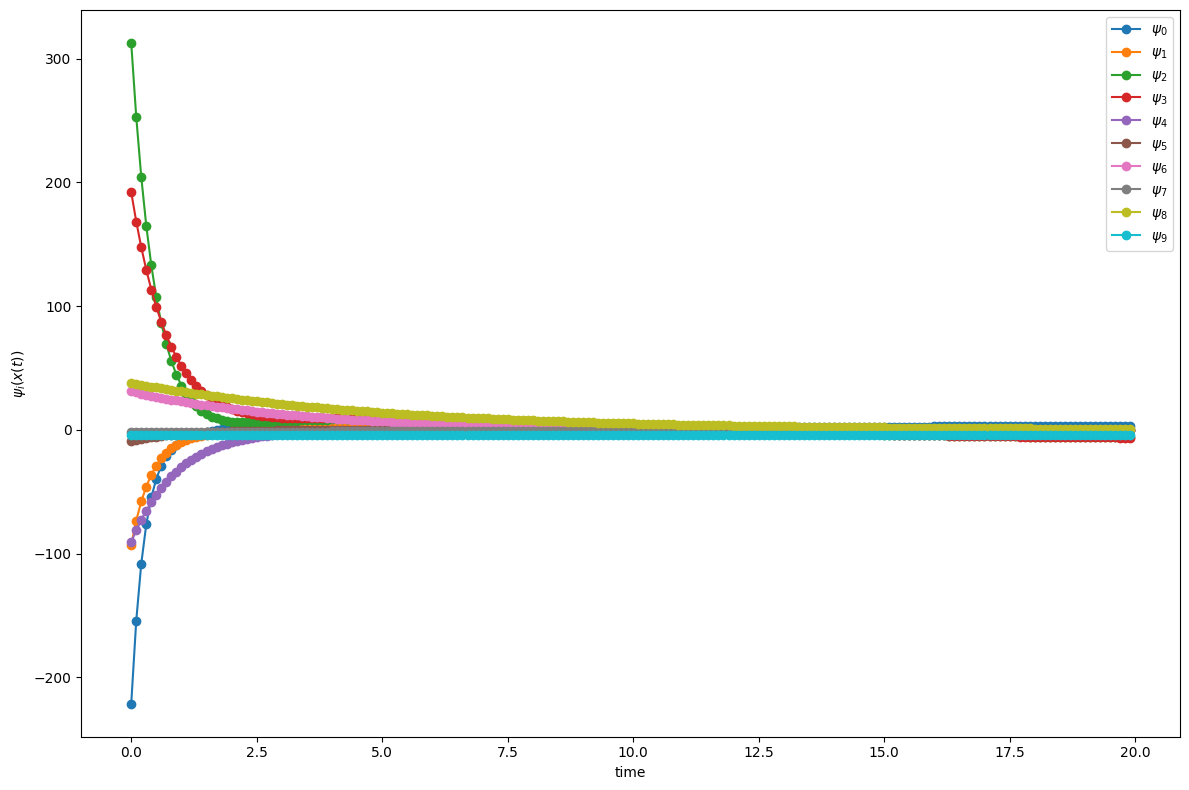

In [20]:
fig, axs = plt.subplots(1, 1, sharex=True, tight_layout=True, figsize=(12, 8))

phi_test = model.psi(Xtest)
# phi_test_int = model.integrate_eigenfunction(t,Xtest[0:1,:])

for i in range(phi_test.shape[0]):
    axs.plot(t, np.real(phi_test)[i,:],'-o', label=r'$\psi_'+str(i)+'$')
    # axs.plot(t, np.real(phi_test_int),'--r', label='EF')

plt.xlabel('time')
plt.ylabel(r'$\psi_i(x(t))$')
plt.legend(loc='best')